# Projekt zaliczeniowy - predykcja cen nieruchomości

## Wstęp


### Dane
Dane wykorzystane w projekcie pochodzą z repozytorium danych [UC Irvine](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set). Dane przedstawiają ceny nieruchomości (na jednostkę powierzchni) w dzielnicy Xindian Nowego Tajpej względem parametrów takich jak np. odległość od stacji metra, liczby sklepów w pobliżu, czy wieku budnku.

### Cel
Celem projektu jest predykcja ceny nieruchomości w zależności od zadanych parametrów. Główną korzyścia utworzonego w projekcie rozwiązania jest ułatwienie i przyśpieszenie procesu wyceny nieruchomości.

## Eksploracja danych
### Pobranie danych

In [1]:
!wget https://archive.ics.uci.edu/static/public/477/real+estate+valuation+data+set.zip
!unzip real+estate+valuation+data+set.zip

--2024-05-26 17:47:17--  https://archive.ics.uci.edu/static/public/477/real+estate+valuation+data+set.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘real+estate+valuation+data+set.zip’

real+estate+valuati     [ <=>                ]  32.11K  --.-KB/s    in 0.06s   

2024-05-26 17:47:17 (527 KB/s) - ‘real+estate+valuation+data+set.zip’ saved [32885]

Archive:  real+estate+valuation+data+set.zip
 extracting: Real estate valuation data set.xlsx  


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

### Analiza wstępna

In [3]:
df = pd.read_excel("Real estate valuation data set.xlsx")

In [4]:
for index, col in enumerate(df.columns):
    print(index + 1, col)

1 No
2 X1 transaction date
3 X2 house age
4 X3 distance to the nearest MRT station
5 X4 number of convenience stores
6 X5 latitude
7 X6 longitude
8 Y house price of unit area


Zbiór danych zawiera 8 kolumn.



*   **No** - liczba porządkowa
*   **X1 transaction date** - data transakcji (sprzedaży/kupna nieruchomości)
*   **X2 house age** - wiek nieruchomości
*   **X3 distance to the nearest MRT station** - dystans do najbliższej stacji metra (w metrach)
*   **X4 number of convinience stores** - liczba sklepów znajdujących się w pobliżu
*   **X5 latutude** - szerokość geograficzna położenia nieruchomości
*   **X6 longitude** - długość geograficzna położenia nieruchomości
*   **Y house price of unit area** - cena nieruchomości na jednostkę powierzchni (10000 dolarów tajwańskich/ping [1 ping = 3.3 metrów kwadratowych])


#### Uproszczenie kolumn




In [5]:
df = df.rename(columns={
    "X1 transaction date": "transaction_date",
    "X2 house age": "age",
    "X3 distance to the nearest MRT station": "distance_to_metro",
    "X4 number of convenience stores": "near_stores_count",
    "X5 latitude": "latitude",
    "X6 longitude": "longitude",
    "Y house price of unit area": "price"
})
df = df.drop("No", axis=1)

df.head()

,transaction_date,age,distance_to_metro,near_stores_count,latitude,longitude,price
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


array([[<Axes: title={'center': 'age'}>]], dtype=object)

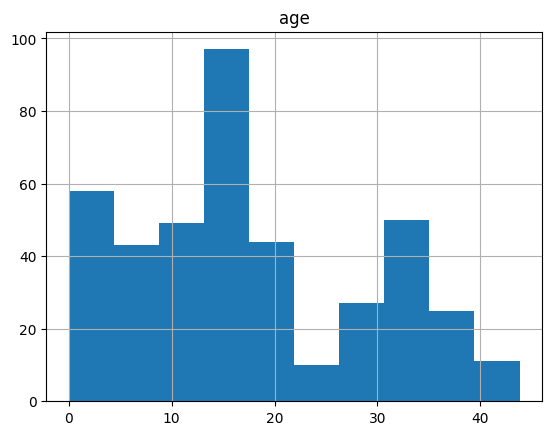

In [6]:
df.hist(column="age")

W przypadku wieku budynku można zauważyć, że w zbiorze występuje więcej nieruchomości o wieku 20 lat lub niższym. Widoczne są dwa szczyty w przedziałach 15-18 lat i 30-35 lat.

array([[<Axes: title={'center': 'distance_to_metro'}>]], dtype=object)

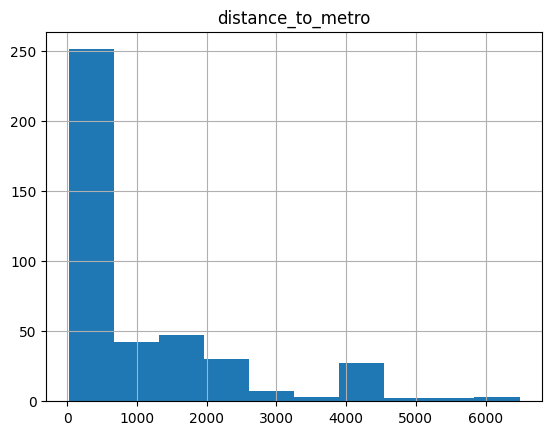

In [7]:
df.hist(column="distance_to_metro")

Większość nieruchomości w zbiorze znajduje się w bliskiej odległości od stacji metra (rozkład mocno prawostronnie skośny).

array([[<Axes: title={'center': 'near_stores_count'}>]], dtype=object)

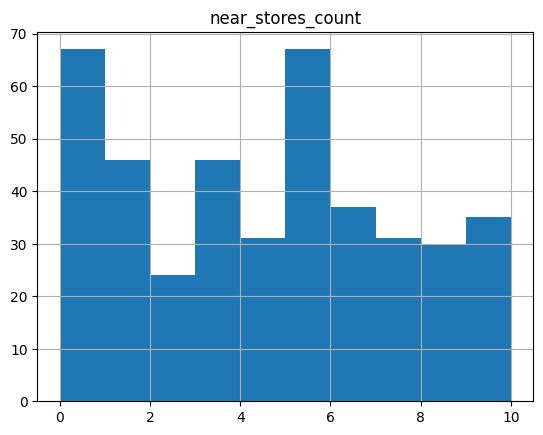

In [8]:
df.hist(column="near_stores_count")

Rozkład liczby sklepów w pobliżu nieruchomości jest dość równomierny. Najwięcej nieruchomości ma jednak w pobliżu pomiędzy 0 a 1 sklepem oraz pomiędzy 5 i 6 sklepami.

array([[<Axes: title={'center': 'price'}>]], dtype=object)

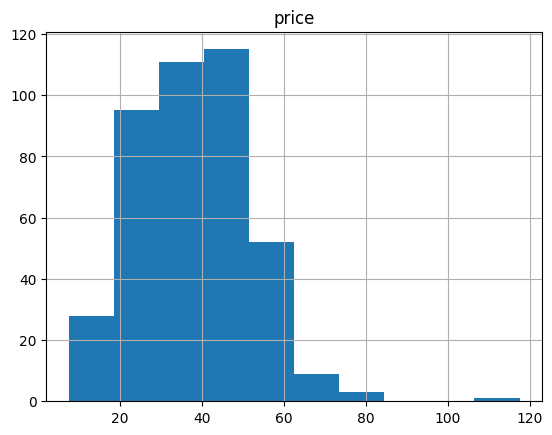

In [9]:
df.hist(column="price")

Rozkład cen nieruchomości jest lekko prawostronnie skośny. Cena większości nieruchmości oscyluje pomiędzy 300  a 500 tys. dolarów tajwańskich. Występują wartości mocno odstające (bardzo drogie nieruchomości - powyżej 800 tys.)

<Axes: xlabel='distance_to_metro', ylabel='price'>

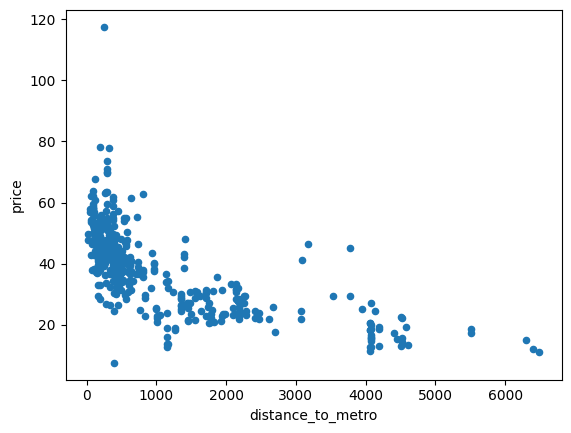

In [10]:
df.plot.scatter(x='distance_to_metro', y='price')

Dystans od najbliższej stacji metra wydaje się być skorelowany z ceną. Nieruchomości znajdujące się w bliskiej odległości od stacji metra są droższe od tych znacząco oddalonych.

<Axes: xlabel='age', ylabel='price'>

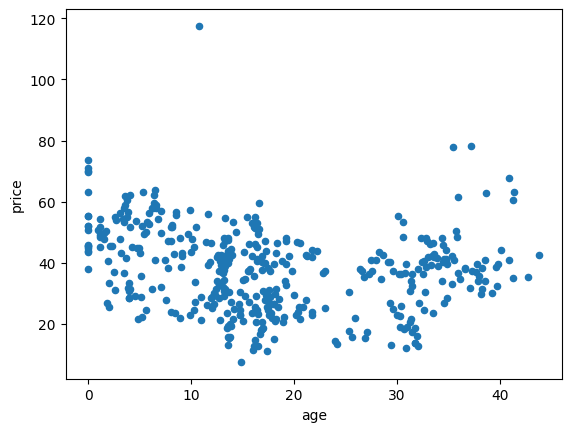

In [11]:
df.plot.scatter(x='age', y='price')

Wiek budynku nie wydaje się mieć dużego wpływu na cenę.

<Axes: title={'center': 'price'}, xlabel='near_stores_count'>

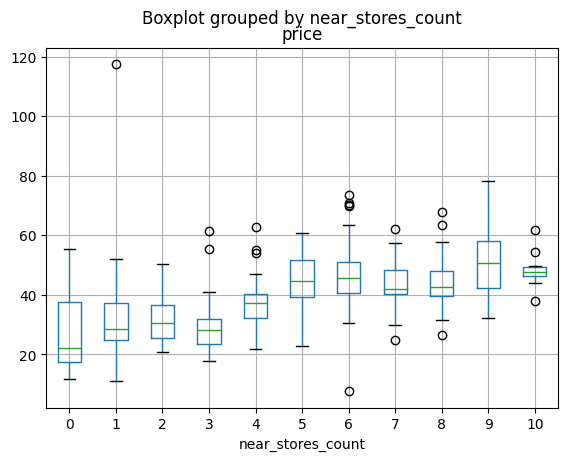

In [12]:
df.boxplot(column="price", by="near_stores_count")

Liczba sklepów w pobliżu nieruchomości wpływa na cenę nieruchomości. Powyżej 5 sklepów wzorst ceny nie jest jednak znaczący.

### Przygotowanie danych

In [13]:
df.isna().sum()

transaction_date     0
age                  0
distance_to_metro    0
near_stores_count    0
latitude             0
longitude            0
price                0
dtype: int64

In [14]:
X = df.drop(['price', 'latitude', 'longitude', 'transaction_date'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ze zbioru zmiennych objaśniających usunięto datę transakcji oraz położenie geograficzne nieruchomości. Same zmienne nie mają dużej wartości predykcyjnej i mogą zabużyć wyniki. Model można jednak rozwinąć budując dodatkowe zmienne na ich podstawie np. odległość od centrum, odległość od najbliższego lotniska etc.


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelowanie
### Regresja liniowa

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_test)


In [19]:
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)

In [20]:
print(f'MSE: {mse_lr}, RMSE: {sqrt(mse_lr)}, MAE: {mae_lr}')

MSE: 58.88825128983575, RMSE: 7.673868078735505, MAE: 5.632384069009171


### Sztuczna sieć *neuronowa*

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler

In [22]:
tf.random.set_seed(42)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [24]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
)

In [25]:
model.build(X_train_scaled.shape)

In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (331, 16)                 64        
                                                                 
 dense_1 (Dense)             (331, 8)                  136       
                                                                 
 dense_2 (Dense)             (331, 8)                  72        
                                                                 
 dense_3 (Dense)             (331, 1)                  9         
                                                                 
Total params: 281 (1.10 KB)
Trainable params: 281 (1.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


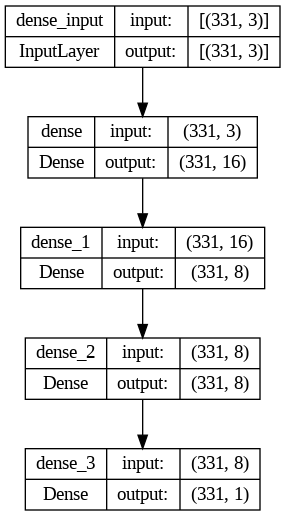

In [27]:
plot_model(model, show_shapes=True)

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=100, verbose=0, validation_split = 0.2)

In [29]:
import matplotlib.pyplot as plt


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

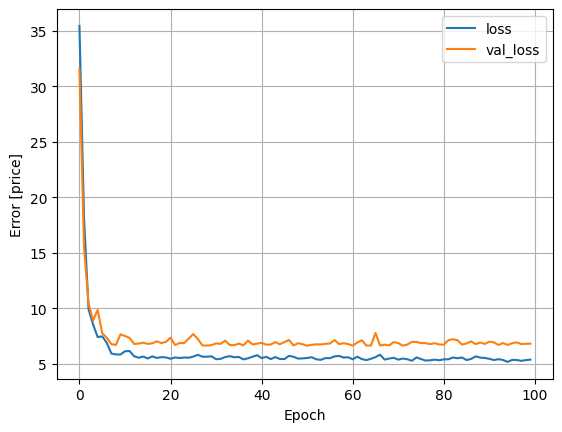

In [30]:
plot_loss(history)

In [31]:
predictions = model.predict(X_test_scaled)


3/3 [==============================] - 0s 3ms/step


In [32]:
mse_dnn = mean_squared_error(y_test, predictions)
mae_dnn = mean_absolute_error(y_test, predictions)

In [33]:
print(f'MSE: {mse_dnn}, RMSE: {sqrt(mse_dnn)}, MAE: {mae_dnn}')

MSE: 47.45760130220592, RMSE: 6.888947764514253, MAE: 4.66006398028638


### Porównanie

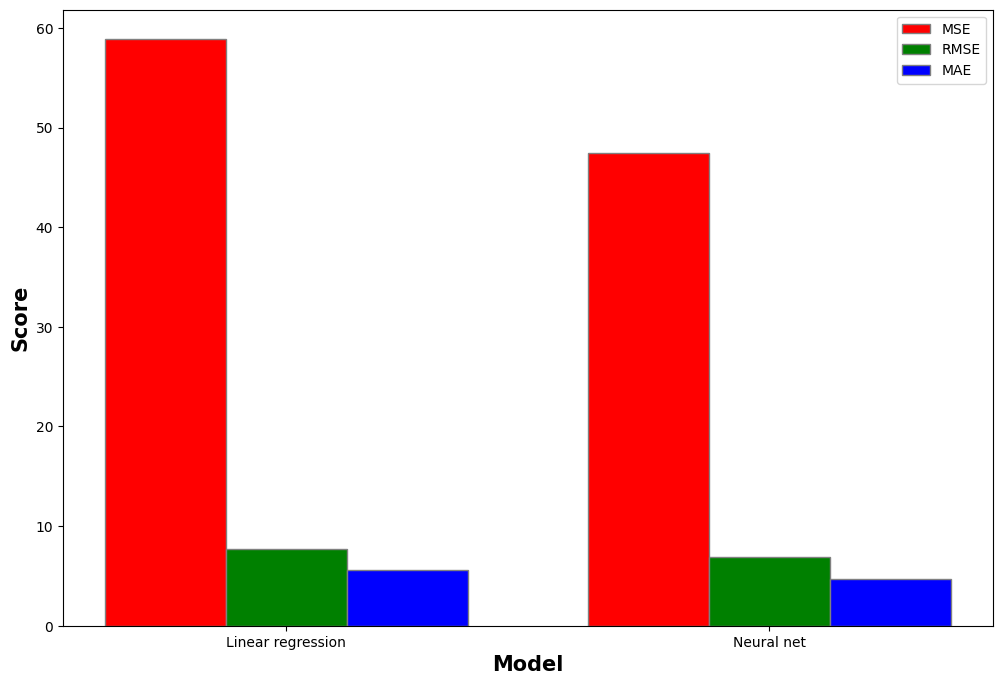

In [34]:

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

MSE = [mse_lr, mse_dnn]
RMSE = [sqrt(mse_lr), sqrt(mse_dnn)]
MAE = [mae_lr, mae_dnn]

br1 = np.arange(len(MSE))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, MSE, color ='r', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br2, RMSE, color ='g', width = barWidth,
        edgecolor ='grey', label ='RMSE')
plt.bar(br3, MAE, color ='b', width = barWidth,
        edgecolor ='grey', label ='MAE')

plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(MSE))],
        ['Linear regression', 'Neural net'])

plt.legend()
plt.show()

Porównanie wyników pokazuje, że lepszym modelem predykcyjnym dla badanych danych jest model sieci neuronowej. Różnica ta nie jest jednak duża, w związku z czym końcowy wybór modelu powinien uwzględnić dodatkowe wymagania np. czas trenowania, zużycie zasobów, wytłumaczalność algorytmu.

## Wnioski


Utworzone na potrzeby projektu modele spełniają założony cel predykcji ceny nieruchomości w zależności od zadanych parametrów. Może zostać on wykorzystany w celu wstępnej analizy cen nieruchomości np. dla nowych inwestycji, znacznie przyśpieszając proces i pozwalając osiągnąć większą konkurencyjność względem ręcznej analizy.